In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch 
from torch import nn, optim
from jcopdl.callback  import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset & Dataloader

In [6]:
from torchvision import datasets, transforms
from jcopdl.utils.dataloader import MultilabelDataset
from torch.utils.data import DataLoader

In [20]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = MultilabelDataset("data/train_label.csv", "data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [9]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

# Arsitekstur & Config

### Contoh Cara Pakai Pre-trained Model

In [10]:
from torchvision.models import mobilenet_v2

In [11]:
mnet = mobilenet_v2(pretrained=True)

/home/zaens/miniconda3/envs/MachineLearning/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zaens/miniconda3/envs/MachineLearning/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/zaens/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


URLError: <urlopen error [Errno -2] Name or service not known>

In [ ]:
for param in mnet.parameters():
    param.requires_grad = False

In [12]:
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

NameError: name 'mnet' is not defined

In [15]:
class CustomMobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, 5),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mnet(x)
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [16]:
config = set_config({
    "output_size" : len(train_set.classes),
    "batch_size" : bs,
    "crop_size" : crop_size
})

# Phase 1 : Adaptation (Learning rate Standard + patience kecil)

In [18]:
model = CustomMobileNet()
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config=config, early_stop_patience=3, outdir="model")

/home/zaens/miniconda3/envs/MachineLearning/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zaens/miniconda3/envs/MachineLearning/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/zaens/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


URLError: <urlopen error [Errno -2] Name or service not known>

In [19]:
from tqdm.auto import tqdm
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature) # feedforward
        loss = criterion(output, target)
        if mode == "train":
            loss.backward() # backpropragation
            optimizer.step() # update weight
            optimizer.zero_grad()
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

In [ ]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    # Logging
    callback.log(train_cost, test_cost)
    # Save CheckPoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Phase 2 : Fine-Tuning (Learning Rate dikecilin & patience ditambah)

In [ ]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5

In [ ]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    # Logging
    callback.log(train_cost, test_cost)
    # Save CheckPoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Predict

In [22]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [23]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5).to(torch.float32)
preds

NameError: name 'model' is not defined

# Sanity Check

In [24]:
def convert_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred==1]
def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

NameError: name 'preds' is not defined

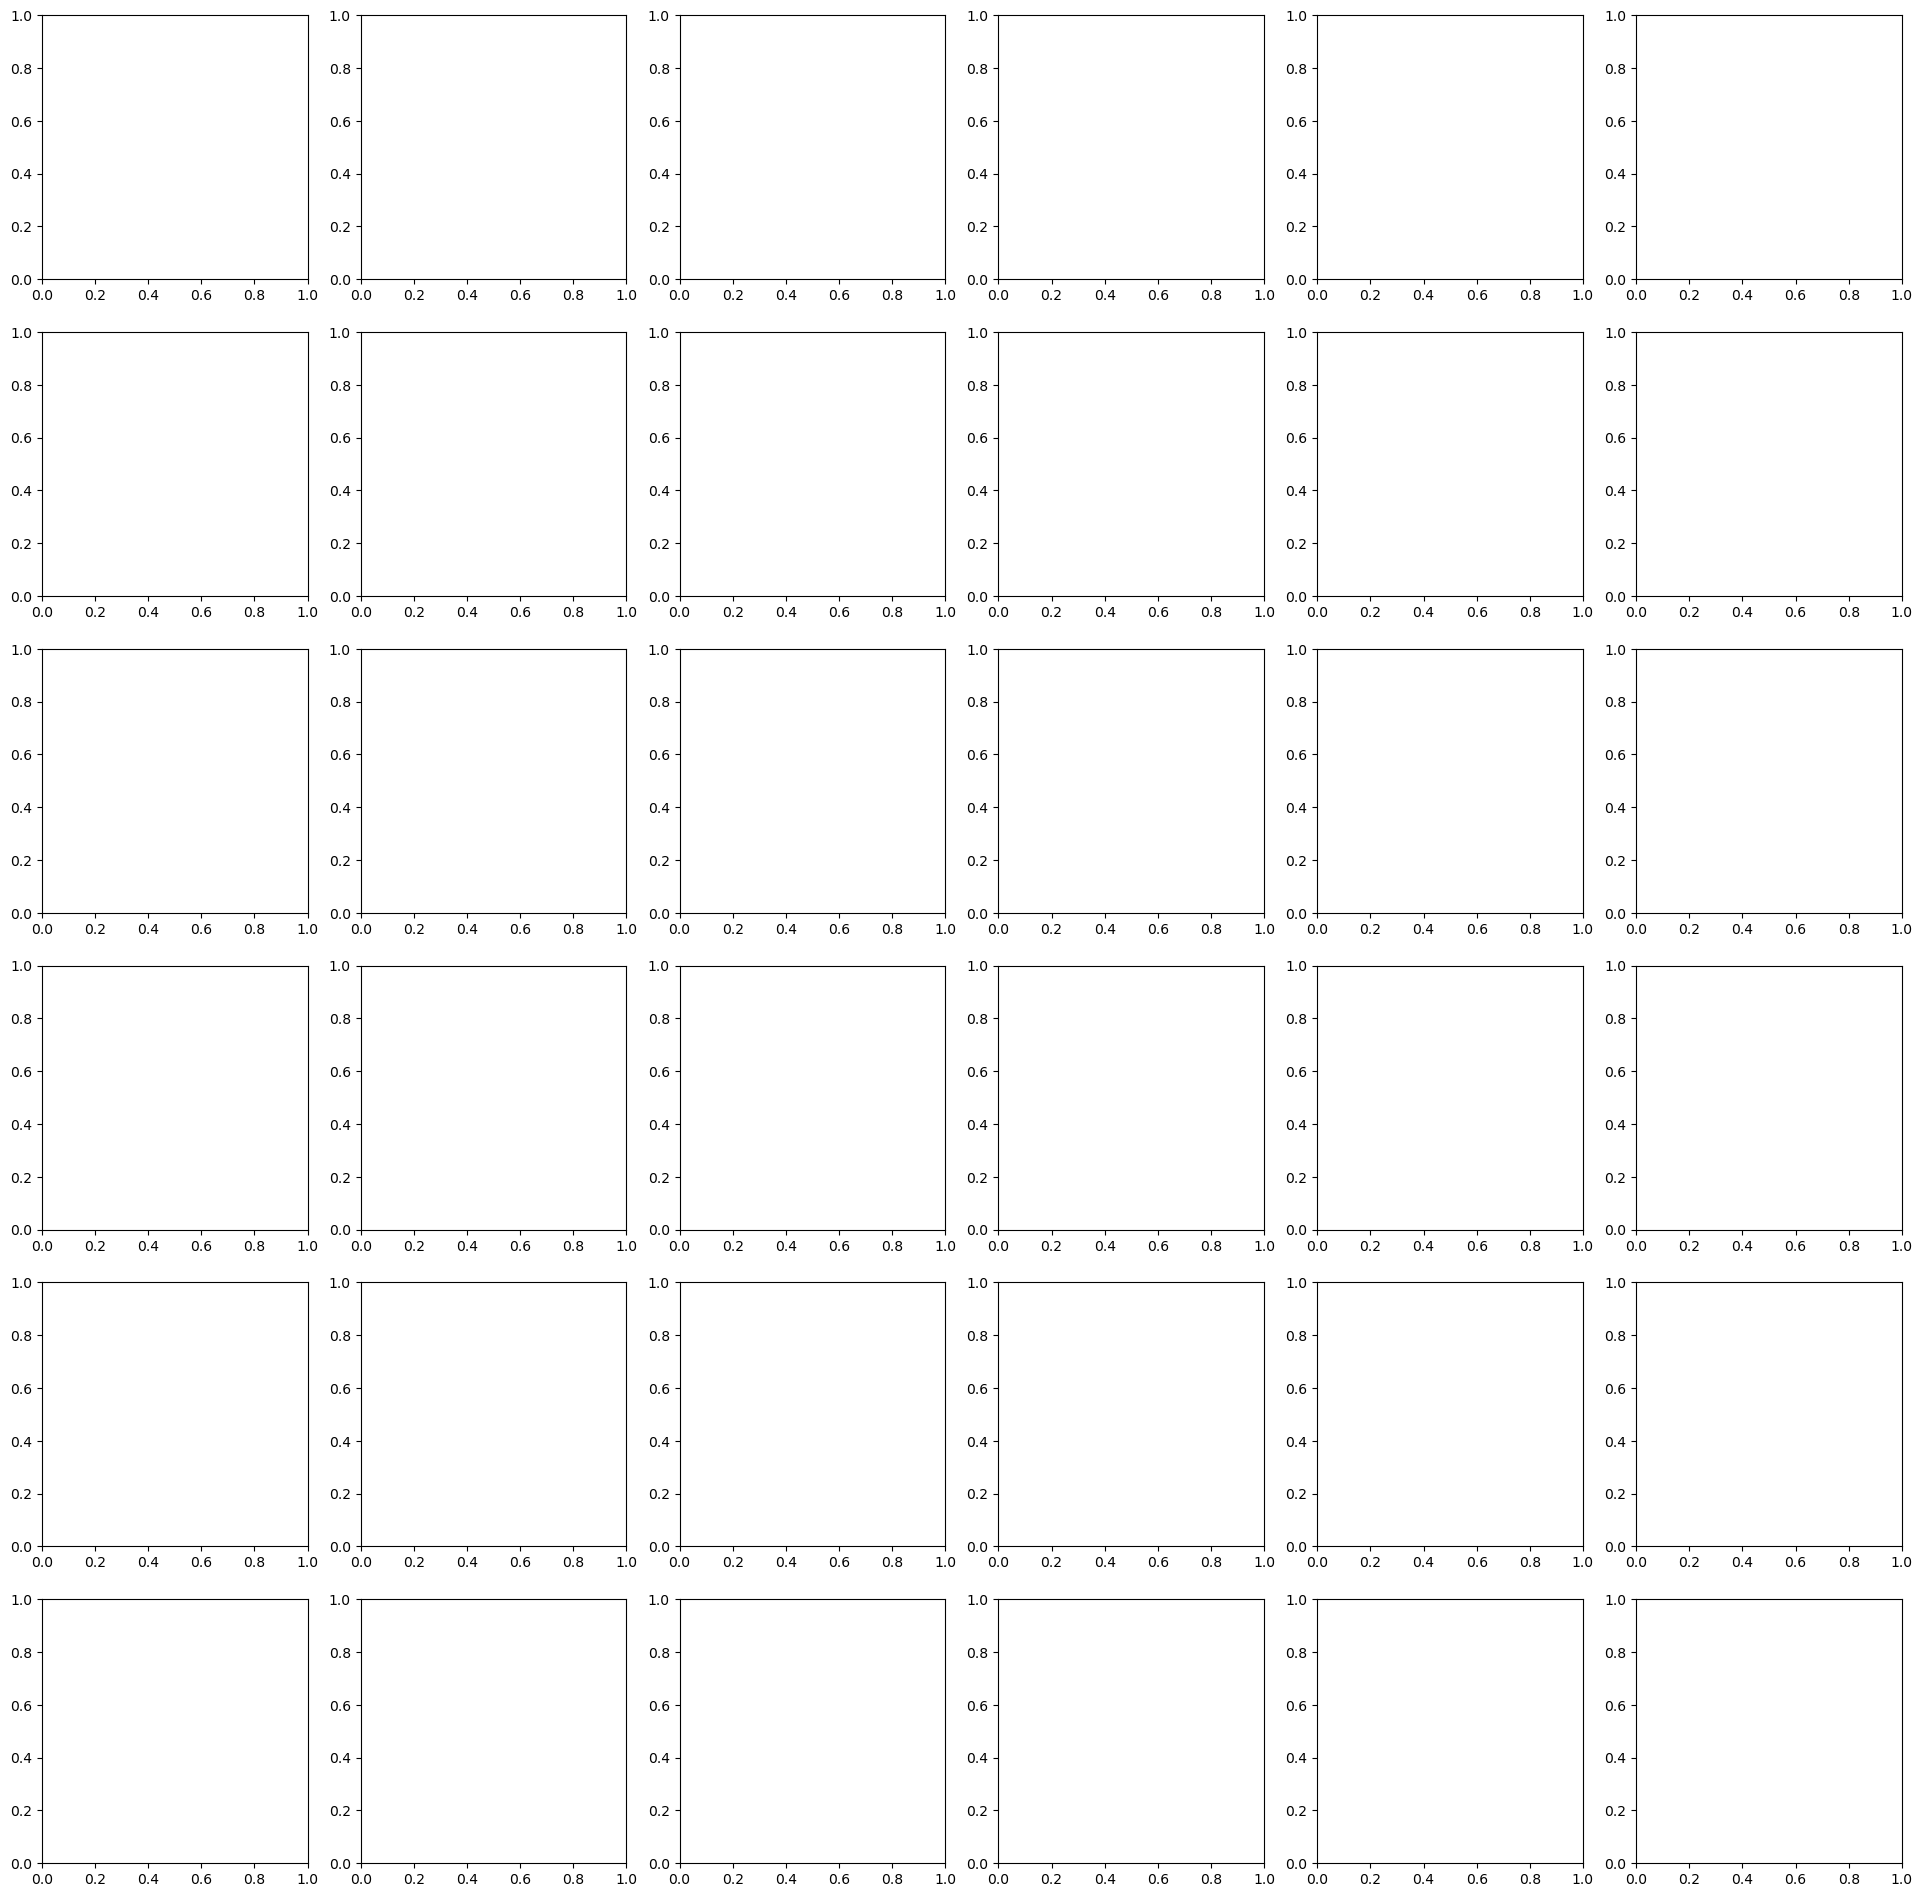

In [25]:
fig, axes = plt.subplots(6, 6, figsize=(24,24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu(), cmap="gray")
    font = {"color" : "r" if (label != pred).any() else "g"}
    label, pred = convert_to_label(label), convert_to_label(pred)
    ax.set_title(f"Label {label} | Pred {pred}", fontdict=font)
    ax.axis('off')